Device: cpu
Dataset shape: (30000, 10)
Categorical unique counts:
  sex: 2
  education: 14
  marital-status: 6
  workclass: 5
  occupation: 12
Embedding sizes: [(2, 1), (14, 7), (6, 3), (5, 3), (12, 6)]
cats_np shape: (30000, 5)
conts_np shape: (30000, 2)
y_np shape: (30000,)
Train shapes: torch.Size([25000, 5]) torch.Size([25000, 2]) torch.Size([25000])
Test shapes: torch.Size([5000, 5]) torch.Size([5000, 2]) torch.Size([5000])
TabularModel(
  (embs): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(14, 7)
    (2): Embedding(6, 3)
    (3): Embedding(5, 3)
    (4): Embedding(12, 6)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin1): Linear(in_features=22, out_features=50, bias=True)
  (bn1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop1): Dropout(p=0.4, inplace=False)
  (out): Linear(in_features=50, out_features=2, bias=True)
)
Epoch 1/300 

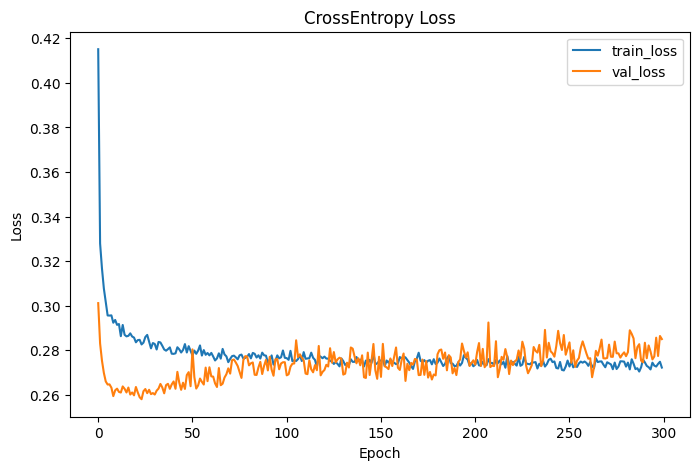

Test Loss: 0.2850
Test Accuracy: 87.54%  (4377/5000)
Example prediction: {'<=50K_prob': 0.20714734494686127, '>50K_prob': 0.7928526401519775, 'pred_class': 1}
Saved model to census_tabular_model.pth


In [4]:
# ===========================
# Census Income Prediction - PyTorch
# Notebook: census_income_workshop.ipynb
# Thanglish comments so neenga easy ah understand & personalize
# ===========================

# 0) Imports
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

# -----------------------
# 1) Reproducibility & device
# -----------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -----------------------
# 2) Load dataset
# -----------------------
# NOTE: place income.csv in repository root or update DATA_PATH
DATA_PATH = os.path.join("..", "income.csv")  # if notebook is inside notebooks/
# If you put income.csv next to notebook, just use "income.csv"
if not os.path.exists(DATA_PATH):
    DATA_PATH = "income.csv"   # fallback
assert os.path.exists(DATA_PATH), f"Cannot find dataset at {DATA_PATH}. Put income.csv in project root or adjust DATA_PATH."

df = pd.read_csv(DATA_PATH)
print("Dataset shape:", df.shape)
df.head()

# -----------------------
# 3) Column selection
# -----------------------
# Per the workshop: 5 categorical, 2 continuous, 1 label named 'label'
# Adjust if your column names slightly differ.
cat_cols = ['sex', 'education', 'marital-status', 'workclass', 'occupation']
cont_cols = ['age', 'hours-per-week']
y_col = 'label'

# Check columns exist
missing = [c for c in (cat_cols + cont_cols + [y_col]) if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns in dataset: {missing}. Rename or adjust column lists accordingly.")

# -----------------------
# 4) Convert categoricals to 'category' dtype
# -----------------------
for c in cat_cols:
    df[c] = df[c].astype('category')

# optional quick EDA print
print("Categorical unique counts:")
for c in cat_cols:
    print(f"  {c}: {df[c].nunique()}")

# -----------------------
# 5) cat_szs and emb_szs
# -----------------------
cat_szs = [int(df[c].nunique()) for c in cat_cols]
# embedding size heuristic: min(50, (n_cat+1)//2)
emb_szs = [(n, min(50, (n+1)//2)) for n in cat_szs]
print("Embedding sizes:", emb_szs)

# -----------------------
# 6) Create cats numpy array (codes) and conts array
# -----------------------
cats_np = np.stack([df[c].cat.codes.values for c in cat_cols], axis=1)
conts_np = np.stack([df[c].values for c in cont_cols], axis=1).astype(np.float32)
y_np = df[y_col].values.astype(np.int64)

print("cats_np shape:", cats_np.shape)
print("conts_np shape:", conts_np.shape)
print("y_np shape:", y_np.shape)

# -----------------------
# 7) scale continuous features
# -----------------------
scaler = StandardScaler()
conts_np = scaler.fit_transform(conts_np)

# -----------------------
# 8) convert to tensors
# -----------------------
cats = torch.tensor(cats_np, dtype=torch.int64)
conts = torch.tensor(conts_np, dtype=torch.float32)
y = torch.tensor(y_np, dtype=torch.long).view(-1)

# -----------------------
# 9) train/test split (25,000 / 5,000)
# -----------------------
n = len(df)
train_size = 25000
test_size = 5000
assert n >= train_size + test_size, f"Dataset has {n} rows; need at least {train_size+test_size}."

# Dataset is already shuffled (per problem). We'll take first train_size as train.
train_idx = np.arange(0, train_size)
test_idx = np.arange(train_size, train_size + test_size)

cat_train = cats[train_idx]
cont_train = conts[train_idx]
y_train = y[train_idx]

cat_test = cats[test_idx]
cont_test = conts[test_idx]
y_test = y[test_idx]

print("Train shapes:", cat_train.shape, cont_train.shape, y_train.shape)
print("Test shapes:", cat_test.shape, cont_test.shape, y_test.shape)

# -----------------------
# 10) DataLoaders
# -----------------------
BATCH_SIZE = 64
train_ds = TensorDataset(cat_train, cont_train, y_train)
test_ds = TensorDataset(cat_test, cont_test, y_test)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

# -----------------------
# 11) TabularModel definition
# -----------------------
class TabularModel(nn.Module):
    def __init__(self, emb_szs, n_cont, hidden_units=50, drop_p=0.4):
        super().__init__()
        # create embedding layers for each categorical col
        self.embs = nn.ModuleList([nn.Embedding(n_cat, emb_dim) for n_cat, emb_dim in emb_szs])
        self.emb_drop = nn.Dropout(drop_p)
        self.n_emb = sum([emb_dim for _, emb_dim in emb_szs])
        # batchnorm for continuous features
        self.bn_cont = nn.BatchNorm1d(n_cont)
        # hidden layer
        self.lin1 = nn.Linear(self.n_emb + n_cont, hidden_units)
        self.bn1 = nn.BatchNorm1d(hidden_units)
        self.drop1 = nn.Dropout(drop_p)
        # output layer (2 classes)
        self.out = nn.Linear(hidden_units, 2)

    def forward(self, x_cat, x_cont):
        # embeddings
        embedded = [emb(x_cat[:, i]) for i, emb in enumerate(self.embs)]
        x = torch.cat(embedded, dim=1)
        x = self.emb_drop(x)
        # continuous branch
        x_cont = self.bn_cont(x_cont)
        # combine
        x = torch.cat([x, x_cont], dim=1)
        # hidden
        x = F.relu(self.bn1(self.lin1(x)))
        x = self.drop1(x)
        # output (logits)
        x = self.out(x)
        return x

# instantiate model and send to device
model = TabularModel(emb_szs, n_cont=len(cont_cols), hidden_units=50, drop_p=0.4).to(device)
print(model)

# -----------------------
# 12) Loss, optimizer, seed (already set above)
# -----------------------
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# -----------------------
# 13) Training loop
# -----------------------
EPOCHS = 300   # for debug set to 30 then increase
history = {'train_loss': [], 'val_loss': []}

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for cat_b, cont_b, y_b in train_loader:
        cat_b = cat_b.to(device)
        cont_b = cont_b.to(device)
        y_b = y_b.to(device)

        optimizer.zero_grad()
        outputs = model(cat_b, cont_b)
        loss = criterion(outputs, y_b)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * y_b.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    history['train_loss'].append(epoch_train_loss)

    # validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for cat_b, cont_b, y_b in test_loader:
            cat_b = cat_b.to(device)
            cont_b = cont_b.to(device)
            y_b = y_b.to(device)
            outputs = model(cat_b, cont_b)
            loss = criterion(outputs, y_b)
            val_loss += loss.item() * y_b.size(0)
    epoch_val_loss = val_loss / len(test_loader.dataset)
    history['val_loss'].append(epoch_val_loss)

    # print progress smaller frequency
    if (epoch + 1) % 25 == 0 or epoch < 5:
        print(f"Epoch {epoch+1}/{EPOCHS}  train_loss: {epoch_train_loss:.4f}  val_loss: {epoch_val_loss:.4f}")

# -----------------------
# 14) Plot training curve
# -----------------------
plt.figure(figsize=(8,5))
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('CrossEntropy Loss')
plt.show()

# -----------------------
# 15) Evaluate on test set: loss + accuracy
# -----------------------
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for cat_b, cont_b, y_b in test_loader:
        cat_b = cat_b.to(device)
        cont_b = cont_b.to(device)
        y_b = y_b.to(device)
        outputs = model(cat_b, cont_b)
        loss = criterion(outputs, y_b)
        test_loss += loss.item() * y_b.size(0)
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == y_b).sum().item()
        total += y_b.size(0)

test_loss = test_loss / total
accuracy = correct / total
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%  ({correct}/{total})")

# -----------------------
# 16) BONUS: function to predict a single new sample
# -----------------------
# create mapping dicts for categories (string->code)
cat_maps = {c: {cat: code for code, cat in enumerate(df[c].cat.categories)} for c in cat_cols}

def predict_sample(sample_dict):
    """
    sample_dict must contain keys for all cat_cols + cont_cols.
    Example:
    sample = {
      'sex':'Male', 'education':'Bachelors', 'marital-status':'Married',
      'workclass':'Private', 'occupation':'Exec-managerial',
      'age': 37, 'hours-per-week': 40
    }
    """
    # map categorical strings to codes
    cat_list = []
    for c in cat_cols:
        val = sample_dict[c]
        if val not in cat_maps[c]:
            raise ValueError(f"Value '{val}' not in known categories for column '{c}'. Allowed: {list(cat_maps[c].keys())}")
        cat_list.append(cat_maps[c][val])

    cont_list = []
    for i, c in enumerate(cont_cols):
        raw = float(sample_dict[c])
        scaled = (raw - scaler.mean_[i]) / scaler.scale_[i]
        cont_list.append(scaled)

    x_cat = torch.tensor([cat_list], dtype=torch.int64).to(device)
    x_cont = torch.tensor([cont_list], dtype=torch.float32).to(device)

    model.eval()
    with torch.no_grad():
        out = model(x_cat, x_cont)
        probs = torch.softmax(out, dim=1).cpu().numpy()[0]
        pred_class = int(np.argmax(probs))
    return {"<=50K_prob": float(probs[0]), ">50K_prob": float(probs[1]), "pred_class": pred_class}

# example usage:
example = {
    'sex':'Male', 'education':'Bachelors', 'marital-status':'Married',
    'workclass':'Private', 'occupation':'Exec-managerial',
    'age':37, 'hours-per-week':40
}
print("Example prediction:", predict_sample(example))

# -----------------------
# 17) Save model & artifacts for reuse
# -----------------------
torch.save({
    'model_state_dict': model.state_dict(),
    'scaler_mean': scaler.mean_.tolist(),
    'scaler_scale': scaler.scale_.tolist(),
    'emb_szs': emb_szs,
    'cat_cols': cat_cols,
    'cont_cols': cont_cols,
    'cat_maps': cat_maps
}, "census_tabular_model.pth")

print("Saved model to census_tabular_model.pth")
